In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

import math
import numpy as np
import pandas as pd
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.spatial import distance

from depth.multivariate import *
from numpy.random import RandomState
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <5310731F-64FC-310E-B88B-E06F64BB3F98> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, z_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), z, mu, logvar

In [8]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Train VAE
def train_model(model, dataloader, learning_rate, num_epochs, max_batches=None):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for bno, batch in enumerate(dataloader):
            if max_batches != None and bno > max_batches :
                break
            x, _ = batch
            x = x.view(x.size(0), -1)
            optimizer.zero_grad()
            recon_x, z, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}')
    return model

In [4]:
# Load Fashion-MNIST dataset
def load_data(normal_class=0):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
    fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)
    
    # Filter out only the normal class
    train_indices = [i for i, (_, label) in enumerate(fashion_mnist_train) if label == normal_class]
    normal_train = Subset(fashion_mnist_train, train_indices)
    
    return normal_train, fashion_mnist_test

In [5]:
# Compute Mahalanobis depth
def compute_mahalanobis_depth(latent_space):
    mean = np.mean(latent_space, axis=0)
    cov = np.cov(latent_space, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    depth = np.array([distance.mahalanobis(x, mean, inv_cov) for x in latent_space])
    return depth

In [14]:
# # Main function
# def main():
normal_train, fashion_mnist_test = load_data(normal_class=0)  # Class 0: T-shirt/top

dataloader = DataLoader(normal_train, batch_size=128, shuffle=True)

# Define VAE model
x_dim = 28 * 28
hidden_dim = 256
latent_dim = 50
model = VAE(x_dim=x_dim, hidden_dim=hidden_dim, z_dim=latent_dim)

# Train VAE
MAX_STEPS = 1000
trained_model = train_model(model, dataloader, learning_rate=1e-4, num_epochs=2, max_batches=MAX_STEPS)

# Obtain latent representations
latent_space = []
labels = []
depths = []
trained_model.eval()
with torch.no_grad():
    for bno, batch in enumerate(fashion_mnist_test):
        if bno > MAX_STEPS : 
            break
        # get latent shape
        x, y = batch
        x = x.view(-1, x.size(0))
        _, z, _, _ = trained_model(x)
        latent_space.append(z.cpu().numpy())
        # y-labels
        labels.append(torch.tensor(y).cpu().numpy())
        # computing data depth
        # print("Computing data depth for batch", bno)
        batch_depths = halfspace(np.array(labels), np.array(latent_space))
        depths.append(batch_depths)
        # print("Added depths for batch", bno) 
        
latent_space = np.concatenate(latent_space, axis=0)
labels = np.concatenate([labels], axis=0)
depths = np.concatenate([batch_depths], axis=0)

print(latent_space.shape)
print(labels.shape)
print(depths.shape)

# if __name__ == "__main__":
#     main()

Epoch 1, Loss: 520.735541015625
Epoch 2, Loss: 437.07751171875
(1001, 50)
(1001,)
(1001,)


In [15]:
print(depths)

[0.         0.04295704 0.1998002  ... 0.         0.         0.4955045 ]


0.46970441510972694


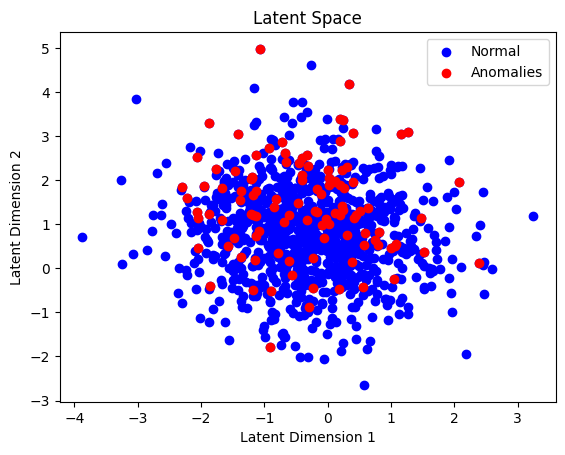

In [45]:
# Set a threshold for anomalies (e.g., top 5% deepest points)
threshold = np.std(depths) * 3  #np.percentile(depths, 95)
print(threshold)
anomalies = depths > threshold

# Visualize latent space with anomalies
plt.scatter(latent_space[:, 0], latent_space[:, 1], c='blue', label='Normal')
plt.scatter(latent_space[anomalies, 0], latent_space[anomalies, 1], c='red', label='Anomalies')
plt.title('Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

In [25]:
anom_depths = depths[anomalies]
anom_depths

array([], dtype=float64)

In [30]:
print(np.min(depths), np.max(depths))
print(np.std(depths))

0.0 0.4955044955044955
0.156568138369909


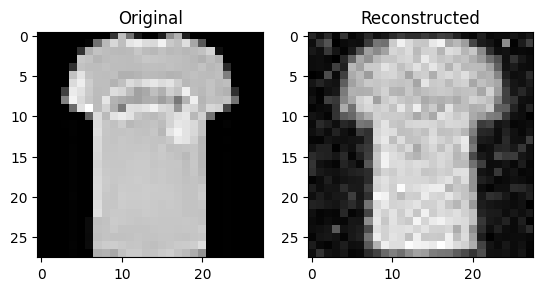

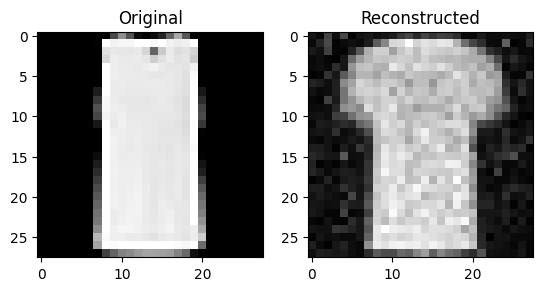

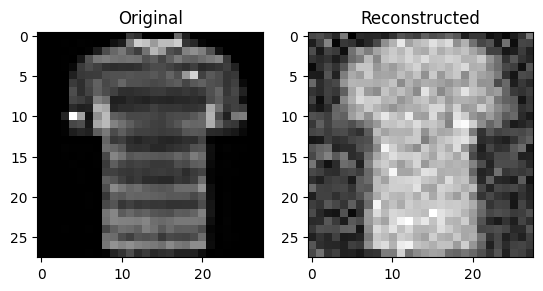

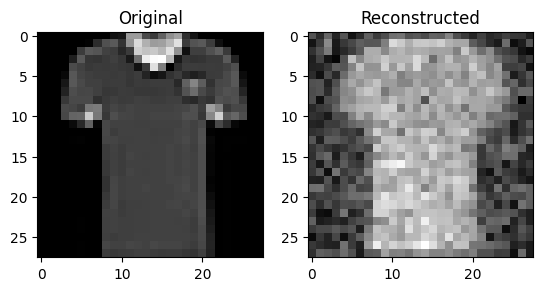

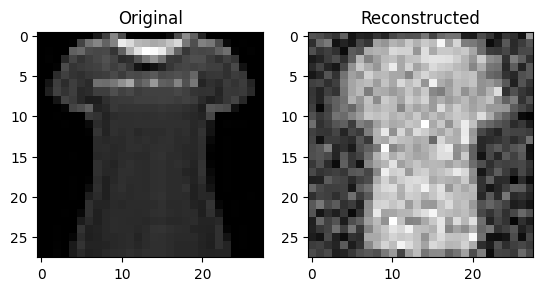

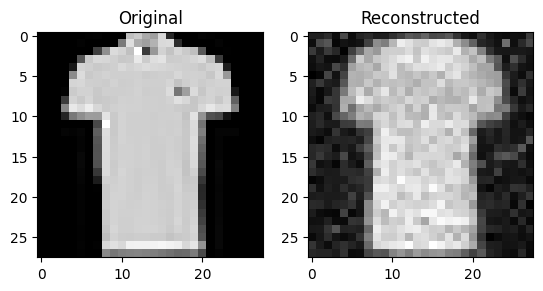

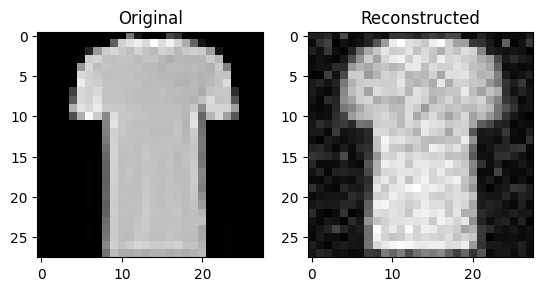

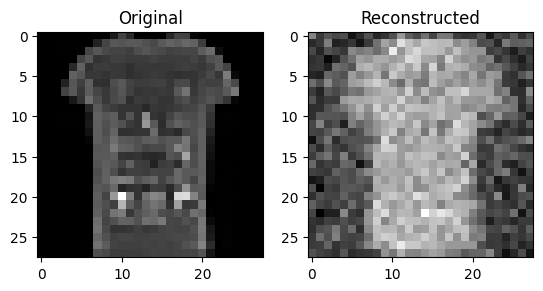

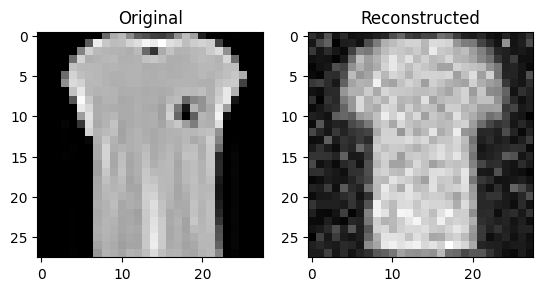

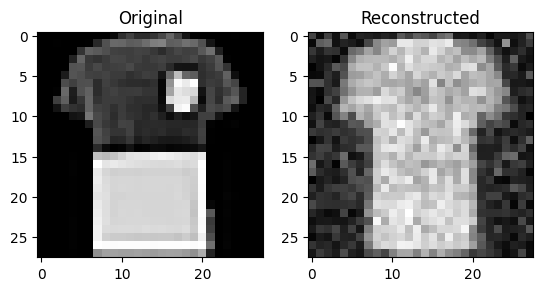

In [48]:
# Visualize original and reconstructed anomalies
anomaly_indices = np.where(anomalies)[0]
for i in anomaly_indices[:10]:  # Show up to 10 anomalies
    original = fashion_mnist_test[i][0].view(28, 28).numpy()
    with torch.no_grad():
        org = fashion_mnist_test[i][0]
        reconstructed, _, _, _ = trained_model(org.view(-1, org.size(0)))
    reconstructed = reconstructed.view(28, 28).numpy()
    
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original')
    axes[1].imshow(reconstructed, cmap='gray')
    axes[1].set_title('Reconstructed')
    plt.show()